In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ukbench100/ukbench00932.jpg
/kaggle/input/ukbench100/ukbench00880.jpg
/kaggle/input/ukbench100/ukbench00831.jpg
/kaggle/input/ukbench100/ukbench00186.jpg
/kaggle/input/ukbench100/ukbench00679.jpg
/kaggle/input/ukbench100/ukbench00948.jpg
/kaggle/input/ukbench100/ukbench00897.jpg
/kaggle/input/ukbench100/ukbench00171.jpg
/kaggle/input/ukbench100/ukbench00731.jpg
/kaggle/input/ukbench100/ukbench00195.jpg
/kaggle/input/ukbench100/ukbench00864.jpg
/kaggle/input/ukbench100/ukbench00835.jpg
/kaggle/input/ukbench100/ukbench00538.jpg
/kaggle/input/ukbench100/ukbench00494.jpg
/kaggle/input/ukbench100/ukbench00421.jpg
/kaggle/input/ukbench100/ukbench00961.jpg
/kaggle/input/ukbench100/ukbench00084.jpg
/kaggle/input/ukbench100/ukbench00251.jpg
/kaggle/input/ukbench100/ukbench00724.jpg
/kaggle/input/ukbench100/ukbench00873.jpg
/kaggle/input/ukbench100/ukbench00085.jpg
/kaggle/input/ukbench100/ukbench00958.jpg
/kaggle/input/ukbench100/ukbench00118.jpg
/kaggle/input/ukbench100/ukbench00

# Brief
We want to explore and compare a few techniques fo assessing image similarity, focusing on 2 distinct levels:
1. **Duplicate or Near-Duplicate Image Detection**:</br>
   This involves identifying images that are nearl identical, with minimal alterations (slight variation in camera angle, lighting conditions, minor cropping. resizing or compression, burst capture of the same scene)</br>
   Detecting these near-duplicates is crucial in applications like photo deduplication, digital asset management, and copyright enforcement.
2. **Semantic Similarity Detection**:</br>
   This level focuses on recognizing images that, while not identical, share similar content or depict the same objects/scenes from different perspectives<br>
   Semantic similarity detection is vital for tasks such as content-based image retrieval, scene understanding etc.
   

# 1. Near-Duplicate Image Detection Techniques

We will try three widely used techniques for this purpose:​

1. **Perceptual Hashing (pHash)**</br>
Purpose: Effective for detecting duplicates where images have undergone slight modifications like resizing, compression, or slight color adjustments.</br>
How It Works: pHash computes a hash value based on the image's perceptual characteristics, capturing its essence. It typically involves:
    * Converting the image to grayscale.
    * Applying a Discrete Cosine Transform (DCT) to extract frequency components.
    * Generating a hash from the low-frequency DCT coefficients, which represent the most significant visual information.

Comparison Metric: Hamming distance between hashes; a smaller distance indicates higher similarity.</br></br>

2. **Average Hashing (aHash)**</br>
Purpose: Simplifies image comparison by reducing images to their average luminance values. Quick and efficient for detecting exact or near-exact duplicates but less robust to significant alterations</br>
How It Works: aHash processes images by:
    * Resizing the image to a smaller, fixed size (e.g., 8x8 pixels).
    * Converting to grayscale.
    * Calculating the average pixel value.
    * Setting each bit in the hash: 1 if the pixel's value is above the average, 0 otherwise.

Comparison Metric: Hamming distance between hashes.</br></br>

3. **Color Histogram Comparison**</br>
Purpose: Analyzes the distribution of colors within an image to identify similarities. Useful for identifying images with similar color compositions; however, it may not be effective if images have similar colors but different content</br>
How It Works: This method involves:
    * Computing histograms for each color channel (e.g., RGB) that represent the frequency of pixel intensities.
    * Comparing these histograms between images using statistical measures.

Comparison Metrics: Commonly used metrics include:

    * Correlation: Measures the linear relationship between histograms.
    * Chi-Square: Assesses the divergence between observed and expected frequencies.
    * Intersection: Calculates the overlapping area between histograms.
    * Bhattacharyya Distance: Evaluates the similarity between two probability distributions.</br>

In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 416 µs (started: 2025-05-09 19:06:38 +00:00)


In [3]:
!pip install imagehash
!pip install opencv-python

time: 5.03 s (started: 2025-05-09 19:06:38 +00:00)


## Let's get the data first

In [4]:
import os
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

time: 1.39 s (started: 2025-05-09 19:06:43 +00:00)


In [5]:
#helper function to visualise images
import matplotlib.pyplot as plt
import math

def show_images_in_grid(images, titles=None, cols=3, figsize=(15, 8)):
    """
    Display a list of images in a grid with optional titles.

    Args:
        images (list): List of images (as NumPy arrays or loaded using PIL/mpimg).
        titles (list): Optional list of titles for each image.
        cols (int): Number of columns in the grid.
        figsize (tuple): Size of the entire figure.
    """
    n_images = len(images)
    rows = math.ceil(n_images / cols)

    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.flatten()  # flatten in case of 2D array

    for i in range(len(axs)):
        if i < n_images:
            axs[i].imshow(images[i])
            axs[i].axis('off')
            if titles:
                axs[i].set_title(titles[i])
        else:
            axs[i].axis('off')  # Hide empty subplots

    plt.tight_layout()
    plt.show()


time: 799 µs (started: 2025-05-09 19:06:44 +00:00)


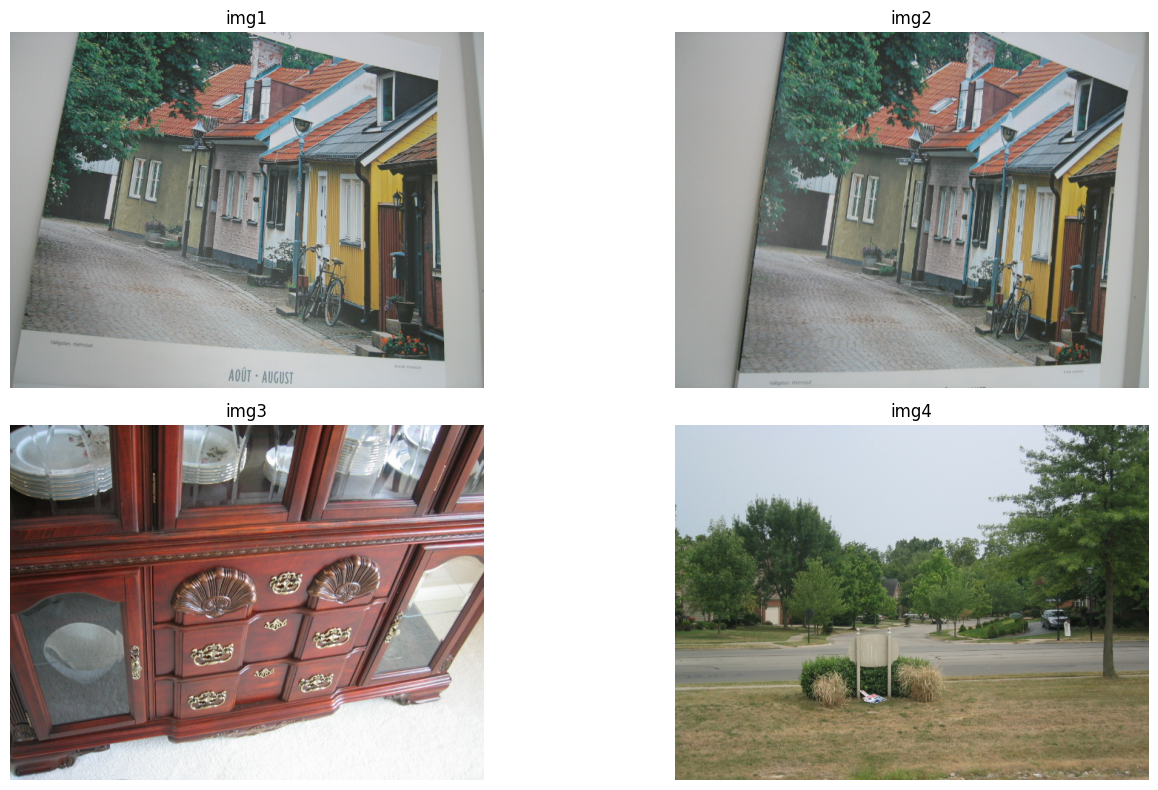

time: 775 ms (started: 2025-05-09 19:06:44 +00:00)


In [6]:
img1_path = "/kaggle/input/ukbench100/ukbench00185.jpg"
img2_path = "/kaggle/input/ukbench100/ukbench00186.jpg"
img3_path ="/kaggle/input/ukbench100/ukbench00281.jpg"
img4_path = "/kaggle/input/ukbench100/ukbench00686.jpg"

img1 = Image.open("/kaggle/input/ukbench100/ukbench00185.jpg")
img2 = Image.open("/kaggle/input/ukbench100/ukbench00186.jpg")
img3 =Image.open("/kaggle/input/ukbench100/ukbench00281.jpg")
img4 =Image.open("/kaggle/input/ukbench100/ukbench00686.jpg")


# Create a 1-row, 2-column grid
show_images_in_grid([img1, img2, img3, img4], titles=["img1", "img2", "img3", "img4"], cols=2, figsize=(15, 8))

*First 2 image is not exact duplicate but have just slight anlge change and coverage. A good example to test our models
last 2 are different from all*

In [7]:
import imagehash
img_size = 224

def load_image(image_path):
    input_image = Image.open(image_path)
    resized_image = input_image.resize((img_size, img_size))

    return resized_image

def compare_hashes(img1, img2, method='phash'):
    if method == 'phash':
        return imagehash.phash(img1) - imagehash.phash(img2)
    elif method == 'ahash':
        return imagehash.average_hash(img1) - imagehash.average_hash(img2)
    else:
        raise ValueError("Unsupported hash method")
    

# image1 = load_image(img_path_1)
# image2 = load_image(img_path_2)

#hash value between similar image
phash_value = compare_hashes(img1, img2, 'phash')
hash_value = compare_hashes(img1, img2, 'ahash')
print(f"phash_value: {phash_value} \nhash_value: {hash_value}")

phash_value: 14 
hash_value: 18
time: 40.8 ms (started: 2025-05-09 19:06:45 +00:00)


In [8]:
#hash values between exact duplicate images
compare_hashes(img1, img1, 'phash'), compare_hashes(img1, img1, 'ahash')

(0, 0)

time: 8.01 ms (started: 2025-05-09 19:06:45 +00:00)


In [9]:
#hash values between not duplicate images
compare_hashes(img1, img3, 'phash'), compare_hashes(img1, img3, 'ahash')

(26, 24)

time: 7.87 ms (started: 2025-05-09 19:06:45 +00:00)


### Let's do Robustness Checks of  hash algo against rotation, lighting. blur, crop and colour adjustments

In [10]:
from PIL import Image, ImageEnhance, ImageFilter
# --- Image Transformations for Robustness Checks ---

def apply_rotation(image, angle=15):
    return image.rotate(angle)

def apply_brightness(image, factor=1.5):
    return ImageEnhance.Brightness(image).enhance(factor)

def apply_blur(image, radius=2):
    return image.filter(ImageFilter.GaussianBlur(radius))

def apply_contrast(image, factor=1.5):
    return ImageEnhance.Contrast(image).enhance(factor)

def apply_color(image, factor=3):
    """
    Enhances the color balance of the image.
    factor > 1 increases color intensity, factor < 1 decreases it.
    """
    enhancer = ImageEnhance.Color(image)
    return enhancer.enhance(factor)

def apply_crop_percent(image, percent=0.1):
    """
    Crops a specified percentage from all sides of the image.

    Parameters:
    - image: PIL.Image object
    - percent: float, fraction to crop from each side (e.g., 0.1 for 10%)

    Returns:
    - Cropped PIL.Image object
    """
    width, height = image.size
    left = int(width * percent)
    top = int(height * percent)
    right = int(width * (1 - percent))
    bottom = int(height * (1 - percent))
    return image.crop((left, top, right, bottom))

TRANSFORMATIONS = {
    "original": lambda img: img,
    "rotated": apply_rotation,
    "brightened": apply_brightness,
    "blurred": apply_blur,
    "high_contrast": apply_contrast,
    "cropped": apply_crop_percent,
    "color_adjusted": apply_color,
}

def test_robustness_against_transformations(base_image, method='phash'):
    """Compare original image with transformed versions and print hash distances."""
    results = {}
    for name, transform in TRANSFORMATIONS.items():
        transformed_img = transform(base_image)
        distance = compare_hashes(base_image, transformed_img, method=method)
        results[name] = distance
        print(f"{method} | Transform: {name:<15} | Hash Distance: {distance}")
    return 
    

time: 6.17 ms (started: 2025-05-09 19:06:46 +00:00)


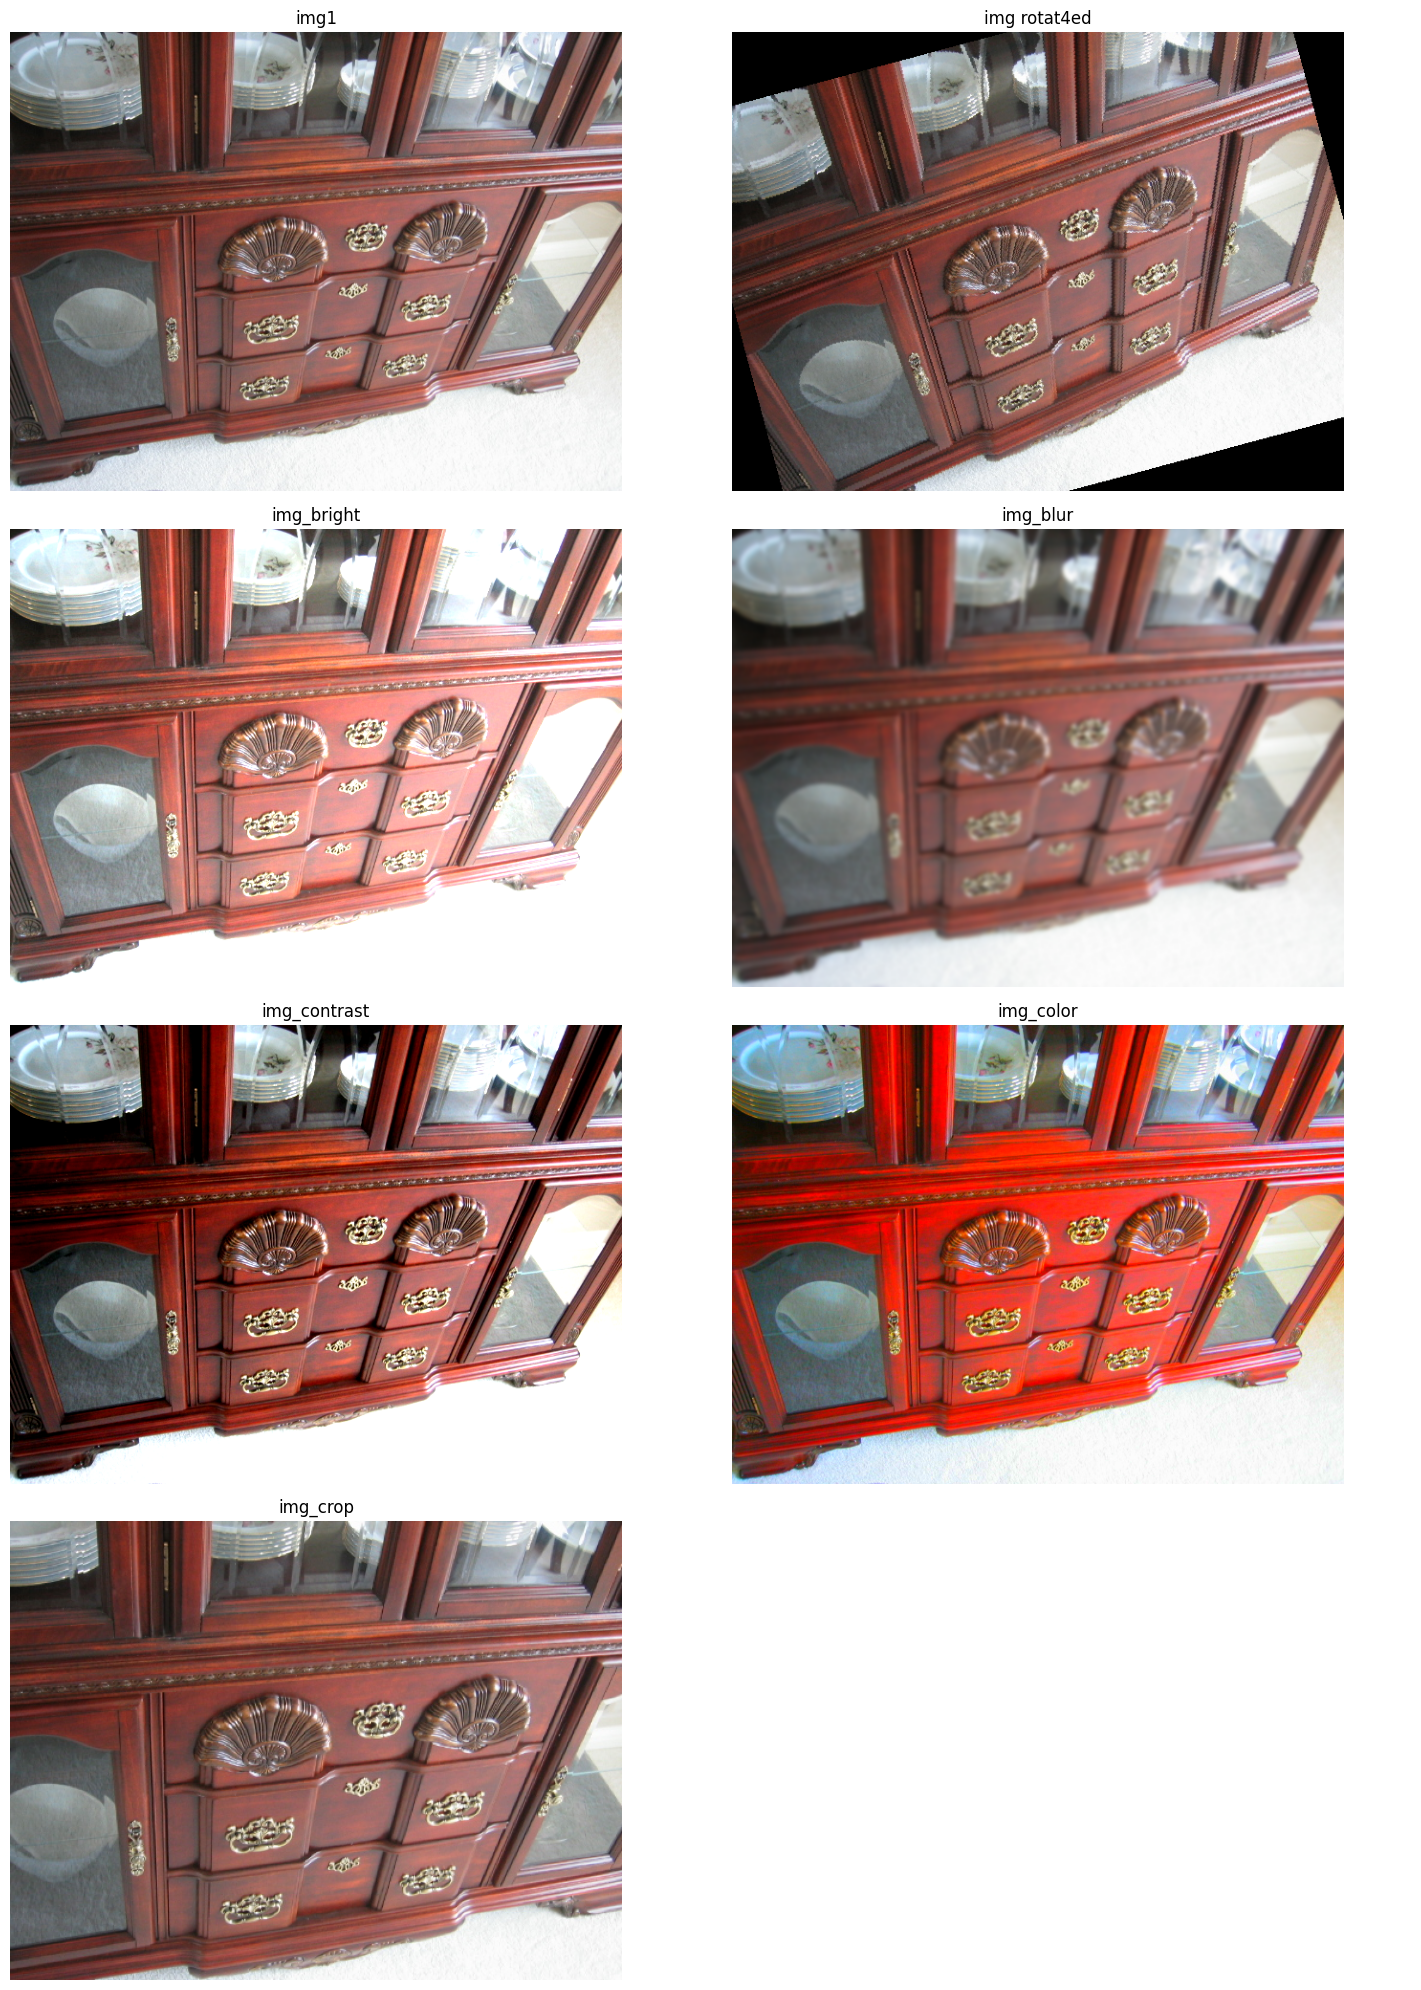

time: 1.56 s (started: 2025-05-09 19:06:46 +00:00)


In [11]:
# visualise different transformations
img_rotated = apply_rotation(img3)
img_bright = apply_brightness(img3)
img_blur = apply_blur(img3)
img_contrast = apply_contrast(img3)
img_color = apply_color(img3)
img_crop = apply_crop_percent(img3)


show_images_in_grid([img3, img_rotated, img_bright, img_blur, img_contrast, img_color, img_crop], 
       titles=["img1", "img rotat4ed", "img_bright", "img_blur", "img_contrast", "img_color", "img_crop"],
        cols=2, figsize=(15, 20))


In [12]:
print("Testing pHash robustness...")
test_robustness_against_transformations(img3, method='phash')

Testing pHash robustness...
phash | Transform: original        | Hash Distance: 0
phash | Transform: rotated         | Hash Distance: 28
phash | Transform: brightened      | Hash Distance: 4
phash | Transform: blurred         | Hash Distance: 0
phash | Transform: high_contrast   | Hash Distance: 0
phash | Transform: cropped         | Hash Distance: 24
phash | Transform: color_adjusted  | Hash Distance: 2
time: 45.3 ms (started: 2025-05-09 19:06:47 +00:00)


In [13]:
print("Testing aHash robustness...")
test_robustness_against_transformations(img3, method='ahash')

Testing aHash robustness...
ahash | Transform: original        | Hash Distance: 0
ahash | Transform: rotated         | Hash Distance: 20
ahash | Transform: brightened      | Hash Distance: 11
ahash | Transform: blurred         | Hash Distance: 0
ahash | Transform: high_contrast   | Hash Distance: 5
ahash | Transform: cropped         | Hash Distance: 15
ahash | Transform: color_adjusted  | Hash Distance: 0
time: 40.3 ms (started: 2025-05-09 19:06:48 +00:00)


## Summary of phash and ahash algo

**pHash is more stable under brightness and contrast changes</br>
Both are sensitive to rotation and cropping.</br>
Both are stable with colour and blur level change</br>
For Contrast, both are acceptable, though aHash shows some drift**


## Histogram for finding Image Similarity

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def calculate_histogram(image_path, color_space='RGB'):
    # Read the image
    image = cv2.imread(image_path)
    
    if color_space == 'RGB':
        channels = ('b', 'g', 'r')  # OpenCV reads images in BGR format
    elif color_space == 'GRAY':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        channels = ('gray',)
    else:
        raise ValueError("Unsupported color space. Use 'RGB' or 'GRAY'.")
    
    histograms = []
    
    for i, channel in enumerate(channels):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        cv2.normalize(hist, hist)
        histograms.append(hist)
    
    return histograms

def compare_histograms(image_path1, image_path2, method=cv2.HISTCMP_CORREL):
    
    # Calculate histograms for each image
    hist1 = calculate_histogram(image_path1, color_space='RGB')
    hist2 = calculate_histogram(image_path2, color_space='RGB')
    
    similarity = 0
    for h1, h2 in zip(hist1, hist2):
        similarity += cv2.compareHist(h1, h2, method)
    return similarity / len(hist1), hist1, hist2

def plot_histograms(hist1, hist2):
    colors = ('b', 'g', 'r')
    plt.figure(figsize=(12, 4))

    for i, (h1, h2, color) in enumerate(zip(hist1, hist2, colors)):
        plt.subplot(1, 3, i + 1)
        plt.plot(h1, color=color, label='Image 1')
        plt.plot(h2, color='k', linestyle='--', label='Image 2')  # black dashed for contrast
        plt.title(f'{color.upper()} Channel')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Normalized Frequency')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Save temp images and compare
def run_histogram_robustness_check(image_path):
    base_image = Image.open(image_path).convert("RGB")
    results = {}

    for name, transform_fn in TRANSFORMATIONS.items():
        transformed_image = transform_fn(base_image)
        temp_path = f"temp_{name}.jpg"
        transformed_image.save(temp_path)

        score, _, _ = compare_histograms(image_path, temp_path)
        results[name] = score

    return results

time: 306 ms (started: 2025-05-09 19:06:48 +00:00)


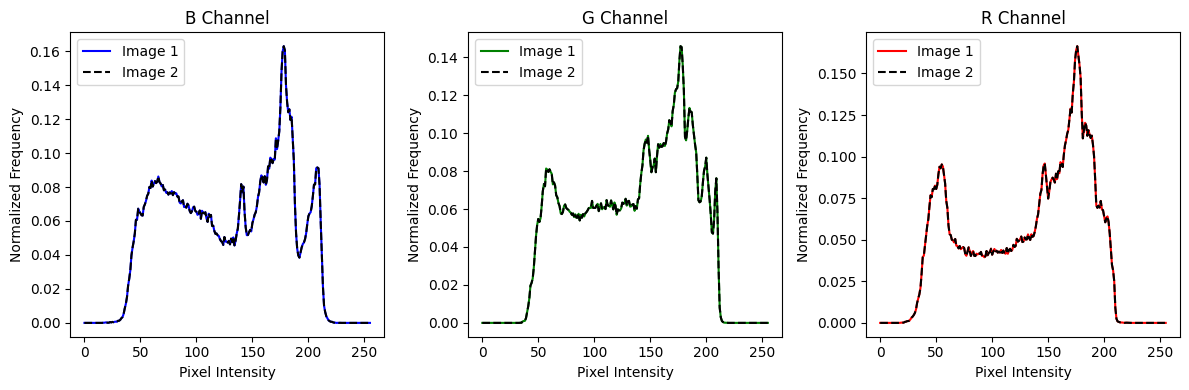

1.0

time: 481 ms (started: 2025-05-09 19:06:48 +00:00)


In [15]:
# hist score for exact duplicate
score, hist1, hist2 = compare_histograms(img1_path, img1_path)
plot_histograms(hist1, hist2)
score

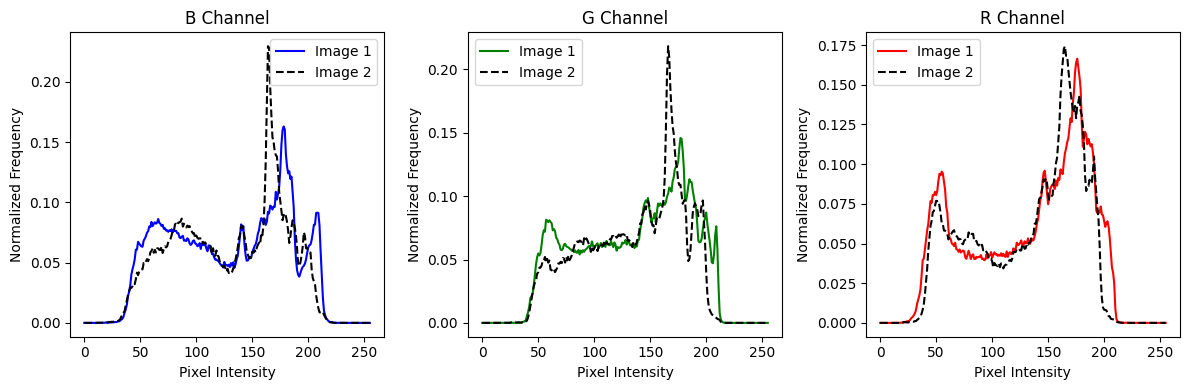

0.8584864463279754

time: 410 ms (started: 2025-05-09 19:06:49 +00:00)


In [16]:
# hist score for near duplicate
score, hist1, hist2 = compare_histograms(img1_path, img2_path)
plot_histograms(hist1, hist2)
score

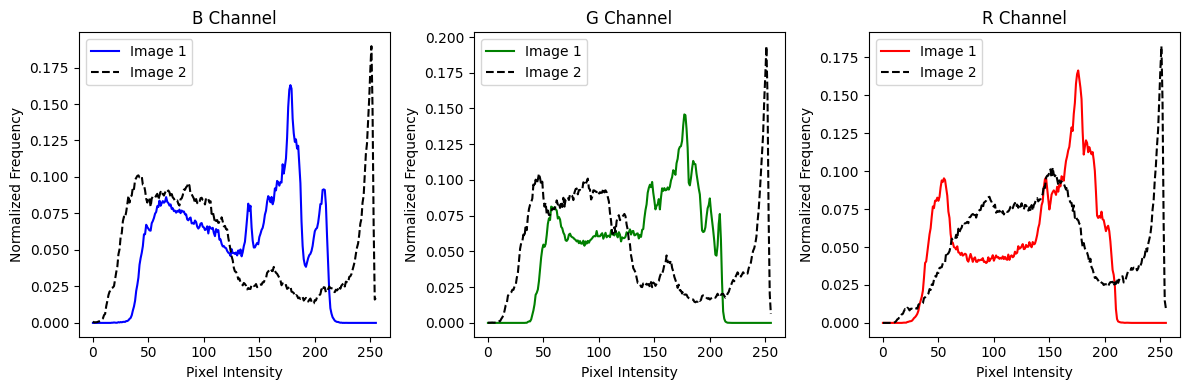

0.08520198823188861

time: 547 ms (started: 2025-05-09 19:06:50 +00:00)


In [17]:
# hist score for not duplicate
score, hist1, hist2 = compare_histograms(img1_path, img3_path)
plot_histograms(hist1, hist2)
score

#### Transformation Robustness Check Using Histogram Similarity

In [18]:
results = run_histogram_robustness_check(img3_path)
for k, v in results.items():
    print(f"Transform: {k.ljust(15)} | Histogram Similarity: {v:.4f}")

Transform: original        | Histogram Similarity: 0.9873
Transform: rotated         | Histogram Similarity: 0.2722
Transform: brightened      | Histogram Similarity: -0.0054
Transform: blurred         | Histogram Similarity: 0.9375
Transform: high_contrast   | Histogram Similarity: -0.0518
Transform: cropped         | Histogram Similarity: 0.8538
Transform: color_adjusted  | Histogram Similarity: 0.4356
time: 73.6 ms (started: 2025-05-09 19:06:50 +00:00)


## Summary of Histogram result

**Histogram similarity is robust to blurring and moderately robust to cropping.</br>It is not robust to rotation, brightness, or contrast changes. </br>Color adjustments (like RGB channel swaps) degrade performance, but not as severely as brightness/contrast. </br>**


# 2. Semantic Similarity Detection Overview
Semantic similarity detection involves comparing images based on their high-level features, such as objects, scenes, and contexts, rather than low-level pixel information. This approach is robust to variations like lighting, orientation, and background changes

We would be using **ViT-B/16, DINOv2, SigLIP, and Perception Encoder** to generate embeddings. We can then calculate the similarity between embeddings using metrics like cosine similarity.